In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

import sys
sys.path.append('..')
from utils.read_utils import load_stickers, load_dataset, load_indicators3, load_horizons
from utils.plot_utils import print_score, inverse_transform, plot_prediction
from algorithms.model import score

In [2]:
# Import the dataset
X_train, X_test, y_train, y_test = load_dataset()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((79002, 27), (19800, 27), (79002, 3), (19800, 3))

In [3]:
X_train.head()

,Symbol,Sector,Close,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MFI_14,STOCHk_14_3_3,STOCHd_14_3_3,RSI_14,...,industry_macds_12_26,sp500_future_macd_12_252,sp500_future_macdh_12_252,sp500_future_macds_12_252,dollar_index_macd_12_252,dollar_index_macdh_12_252,dollar_index_macds_12_252,constant_maturity_macd_12_26,constant_maturity_macdh_12_26,constant_maturity_macds_12_26
2018-01-12,AAPL,Information Technology,44.272499,0.279049,0.070511,0.208537,49.448601,86.786413,79.241559,63.933113,...,10.904313,258.996478,17.345854,241.650624,-3.884604,-0.285202,-3.599402,-0.013031,0.008353,-0.021384
2018-01-16,AAPL,Information Technology,44.047501,0.299277,0.072592,0.226685,56.387717,84.778499,83.724224,60.286756,...,11.585355,272.713460,17.166527,255.546933,-4.130166,-0.378979,-3.751187,-0.015600,0.003290,-0.018891
2018-01-17,AAPL,Information Technology,44.775002,0.369749,0.114451,0.255298,66.314712,87.455489,86.340133,66.866883,...,12.413647,277.316124,17.415353,259.900771,-4.286488,-0.428241,-3.858247,-0.016080,0.002249,-0.018328
2018-01-18,AAPL,Information Technology,44.814999,0.423939,0.134913,0.289026,73.389883,85.987594,86.073860,67.188769,...,13.294427,279.748077,15.877844,263.870232,-4.427213,-0.455173,-3.972040,-0.012283,0.004836,-0.017119
2018-01-19,AAPL,Information Technology,44.615002,0.445611,0.125267,0.320343,65.569700,91.451444,88.298176,63.848590,...,14.161947,283.602023,15.785433,267.816591,-4.534870,-0.450263,-4.084606,-0.008371,0.006999,-0.015370


In [4]:
y_train.head()

,Symbol,Sector,Close_after_1_day
2018-01-12,AAPL,Information Technology,44.047501
2018-01-16,AAPL,Information Technology,44.775002
2018-01-17,AAPL,Information Technology,44.814999
2018-01-18,AAPL,Information Technology,44.615002
2018-01-19,AAPL,Information Technology,44.250000


In [5]:
# Import indicators and horizons
technical_indicators, fundamental_indicators, combined_indicators = load_indicators3()
horizons, horizons_7 = load_horizons()
len(technical_indicators), len(fundamental_indicators), len(combined_indicators)

(10, 16, 25)

In [6]:
from sklearn.svm import SVR 
svr = SVR()
svr

SVR()

# For one company

## Find the best super parameters of SVR (C, kernel)

In [7]:
# Training sets were further split into training and validation sets (using the 80-20 split and preserving chronological order)
X_train_one = X_train.loc[X_train['Symbol'] == "AAPL"].copy()
y_train_one = y_train.loc[X_train['Symbol'] == "AAPL"].copy() 
X_train_split = X_train_one.iloc[:int(4/5*(len(X_train_one)))].copy()
X_valid_split = X_train_one.iloc[int(4/5*(len(X_train_one))):].copy()
y_train_split = y_train_one.iloc[:int(4/5*(len(X_train_one)))].copy()
y_valid_split = y_train_one.iloc[int(4/5*(len(X_train_one))):].copy()
X_train_one.shape, X_train_split.shape, X_valid_split.shape, y_train_split.shape, y_valid_split.shape

((798, 27), (638, 27), (160, 27), (638, 3), (160, 3))

In [8]:
# Normalizing the data set 
X_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaler.fit_transform(X_train_split[combined_indicators])
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler.fit_transform(y_train_split.loc[: ,horizons])
X_scaler

MinMaxScaler()

In [9]:
X_train_split[combined_indicators] = X_scaler.transform(X_train_split[combined_indicators])
X_valid_split[combined_indicators] = X_scaler.transform(X_valid_split[combined_indicators])
X_train_split.head()

,Symbol,Sector,Close,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MFI_14,STOCHk_14_3_3,STOCHd_14_3_3,RSI_14,...,industry_macds_12_26,sp500_future_macd_12_252,sp500_future_macdh_12_252,sp500_future_macds_12_252,dollar_index_macd_12_252,dollar_index_macdh_12_252,dollar_index_macds_12_252,constant_maturity_macd_12_26,constant_maturity_macdh_12_26,constant_maturity_macds_12_26
2018-01-12,AAPL,Information Technology,0.138911,0.603847,0.532401,0.560666,0.410778,0.879284,0.801173,0.666358,...,0.737706,0.929246,0.760467,0.911928,0.197569,0.253106,0.219259,0.271195,0.470645,0.227030
2018-01-16,AAPL,Information Technology,0.135329,0.606318,0.533065,0.563201,0.514713,0.858802,0.848522,0.609731,...,0.742704,0.946730,0.759739,0.930947,0.172437,0.215096,0.201836,0.254559,0.395169,0.246413
2018-01-17,AAPL,Information Technology,0.146911,0.614925,0.546421,0.567198,0.663402,0.886109,0.876153,0.711919,...,0.748782,0.952597,0.760749,0.936906,0.156438,0.195129,0.189547,0.251457,0.379644,0.250784
2018-01-18,AAPL,Information Technology,0.147548,0.621544,0.552950,0.571909,0.769375,0.871136,0.873341,0.716918,...,0.755246,0.955697,0.754510,0.942338,0.142036,0.184213,0.176485,0.276032,0.418213,0.260184
2018-01-19,AAPL,Information Technology,0.144364,0.624191,0.549873,0.576284,0.652243,0.926870,0.896835,0.665046,...,0.761613,0.960609,0.754135,0.947739,0.131017,0.186203,0.163563,0.301357,0.450448,0.273786


In [10]:
y_train_split.loc[: ,horizons] = y_scaler.transform(y_train_split.loc[: ,horizons])
y_valid_split.loc[: ,horizons] = y_scaler.transform(y_valid_split.loc[: ,horizons])
y_train_split.head()

,Symbol,Sector,Close_after_1_day
2018-01-12,AAPL,Information Technology,0.135329
2018-01-16,AAPL,Information Technology,0.146911
2018-01-17,AAPL,Information Technology,0.147548
2018-01-18,AAPL,Information Technology,0.144364
2018-01-19,AAPL,Information Technology,0.138553



RMSE using Technical Indicators to Predict Price by SVR
0.33649892128762315


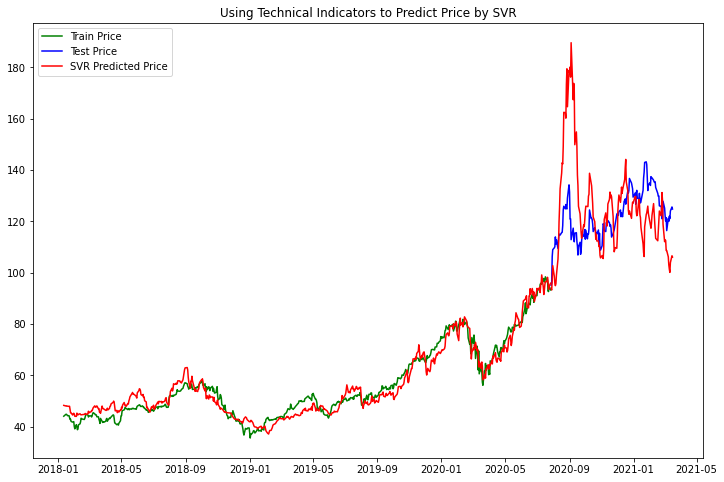

In [18]:
plt.figure(figsize=(12,8))
svr = SVR(C=0.3, kernel='poly', gamma=3, max_iter=1000000)
svr.fit(X_train_split[technical_indicators], y_train_split['Close_after_1_day'])
preds_train = svr.predict(X_train_split[technical_indicators])
preds_valid = svr.predict(X_valid_split[technical_indicators])
print_score("Technical Indicators", horizons, "SVR", y_valid_split, preds_valid)
plot_prediction("Technical Indicators", horizons, "SVR", y_scaler, y_train_split, y_valid_split, preds_train, preds_valid)

### Selection of regularization coefficient C

In [14]:
c_range = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
rms_mean = []

# C = 1/lamda: larger C causes overfitting, smaller C causes underfitting
for c in c_range:
    svr = SVR(C=c, kernel='poly', max_iter=1000000)
    rms = []
    
    svr.fit(X_train_split[technical_indicators], y_train_split['Close_after_1_day'])
    rms.append(score(horizons, y_valid_split, svr.predict(X_valid_split[technical_indicators])))
    svr.fit(X_train_split[fundamental_indicators], y_train_split['Close_after_1_day'])
    rms.append(score(horizons, y_valid_split, svr.predict(X_valid_split[fundamental_indicators])))
    svr.fit(X_train_split[combined_indicators], y_train_split['Close_after_1_day'])
    rms.append(score(horizons, y_valid_split, svr.predict(X_valid_split[combined_indicators])))
        
    print("c:"+str(c)+", mean:"+str(np.mean(rms)))
        
    rms_mean.append(np.mean(rms))

c:0.001, mean:0.3242164356109655
c:0.003, mean:0.3150721155304544
c:0.01, mean:0.3126298341097482
c:0.03, mean:0.327317158802271
c:0.1, mean:0.3240173326260631
c:0.3, mean:0.3013594499687883


<function matplotlib.pyplot.show(close=None, block=None)>

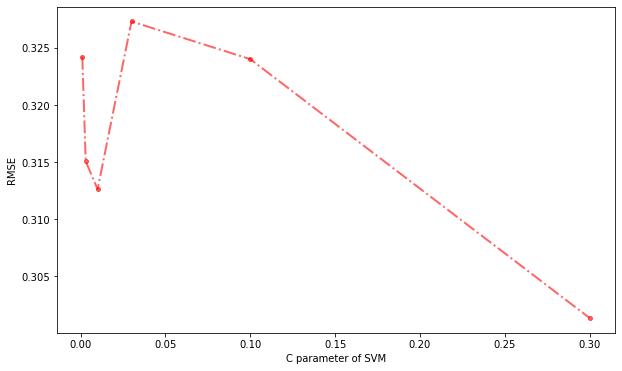

In [15]:
# Plot
plt.figure(figsize = (10, 6))
plt.plot(c_range, rms_mean, linestyle = '-.', linewidth = 2, color = 'r', alpha = 0.6, marker = 'o', markersize = 4)
plt.xlabel('C parameter of SVM')
plt.ylabel('RMSE')
plt.show

### Selection of activation function

In [12]:
kernels = ['linear', 'poly', 'rbf']
rms_mean = []

for kernel in kernels:
    svr = SVR(C=0.02, kernel=kernel, max_iter=1000000)
    rms = []
    
    svr.fit(X_train_split[technical_indicators], y_train_split['Close_after_1_day'])
    rms.append(score(horizons, y_valid_split, svr.predict(X_valid_split[technical_indicators])))
    svr.fit(X_train_split[fundamental_indicators], y_train_split['Close_after_1_day'])
    rms.append(score(horizons, y_valid_split, svr.predict(X_valid_split[fundamental_indicators])))
    svr.fit(X_train_split[combined_indicators], y_train_split['Close_after_1_day'])
    rms.append(score(horizons, y_valid_split, svr.predict(X_valid_split[combined_indicators])))
    
    print("kernel:"+str(kernel)+", mean:"+str(np.mean(rms)))
        
    rms_mean.append(np.mean(rms))

kernel:linear, mean:0.4205980529883573
kernel:poly, mean:0.323184794580103
kernel:rbf, mean:0.8559560735250606


Text(0, 0.5, 'RMSE')

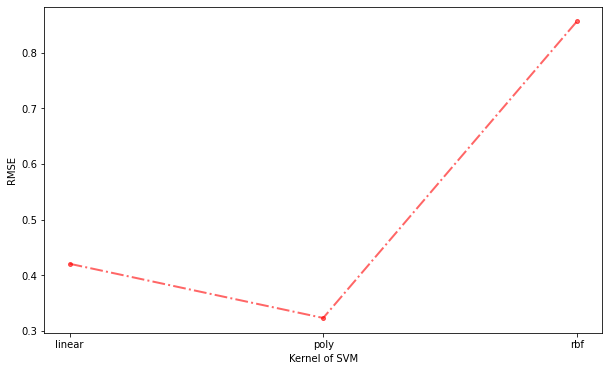

In [13]:
# Plot
plt.figure(figsize = (10, 6))
plt.plot(kernels, rms_mean, linestyle = '-.', linewidth = 2, color = 'r', alpha = 0.6, marker = 'o', markersize = 4)
plt.xlabel('Kernel of SVM')
plt.ylabel('RMSE')

### Selection of gamma parameters in rbf

In [16]:
gamma_range = [0.1, 0.3, 1, 3, 10]
rms_mean = []

for gamma in gamma_range:
    svr = SVR(C=0.3, kernel='poly', gamma=gamma, max_iter=1000000)
    rms = []
    
    svr.fit(X_train_split[technical_indicators], y_train_split['Close_after_1_day'])
    rms.append(score(horizons, y_valid_split, svr.predict(X_valid_split[technical_indicators])))
    svr.fit(X_train_split[fundamental_indicators], y_train_split['Close_after_1_day'])
    rms.append(score(horizons, y_valid_split, svr.predict(X_valid_split[fundamental_indicators])))
    svr.fit(X_train_split[combined_indicators], y_train_split['Close_after_1_day'])
    rms.append(score(horizons, y_valid_split, svr.predict(X_valid_split[combined_indicators])))
    
    print("gamma:"+str(gamma)+", mean:"+str(np.mean(rms)))
        
    rms_mean.append(np.mean(rms))

gamma:0.1, mean:0.38619549852642
gamma:0.3, mean:0.2955322601347005
gamma:1, mean:0.3250202065739247
gamma:3, mean:0.24971205401303856
gamma:10, mean:0.24980483780070695


Text(0, 0.5, 'RMSE')

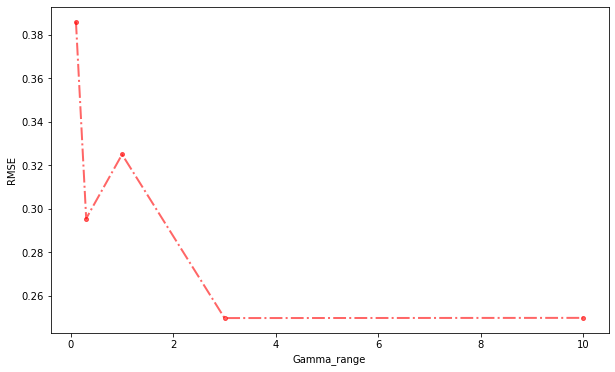

In [17]:
# Plot
plt.figure(figsize = (10, 6))
plt.plot(gamma_range, rms_mean, linestyle = '-.', linewidth = 2, color = 'r', alpha = 0.6, marker = 'o', markersize = 4)
plt.xlabel('Gamma_range')
plt.ylabel('RMSE')

# For all conpanies

## Find the best super parameters of SVR (C, kernel)

In [12]:
# Get the symbols of S&P 100
tickers = load_stickers()
tickers[:5]

,Symbol,Sector
0,AAPL,Information Technology
1,ABBV,Health Care
2,ABT,Health Care
3,ACN,Information Technology
4,ADBE,Information Technology


In [13]:
# Training sets were further split into training and validation sets (using the 80-20 split and preserving chronological order)
X_train_split = pd.DataFrame()
X_valid_split = pd.DataFrame()
y_train_split = pd.DataFrame()
y_valid_split = pd.DataFrame()
for ticker in tickers['Symbol']: 
    X_train_one = pd.DataFrame()
    y_train_one = pd.DataFrame()
    X_train_one = X_train.loc[X_train['Symbol'] == ticker]
    y_train_one = y_train.loc[y_train['Symbol'] == ticker]
    X_train_split = pd.concat([X_train_split, X_train_one.iloc[:int(4/5*(len(X_train_one)))]], axis=0)
    X_valid_split = pd.concat([X_valid_split, X_train_one.iloc[int(4/5*(len(X_train_one))):]], axis=0)
    y_train_split = pd.concat([y_train_split, y_train_one.iloc[:int(4/5*(len(y_train_one)))]], axis=0)
    y_valid_split = pd.concat([y_valid_split, y_train_one.iloc[int(4/5*(len(y_train_one))):]], axis=0)
X_train.shape, y_train.shape, X_train_split.shape, X_valid_split.shape, y_train_split.shape, y_valid_split.shape

((79002, 27), (79002, 3), (63162, 27), (15840, 27), (63162, 3), (15840, 3))

In [14]:
# Normalizing the data set 
X_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaler.fit_transform(X_train_split[combined_indicators])
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler.fit_transform(y_train_split.loc[: ,horizons])

array([[0.01252742],
       [0.01275505],
       [0.01276756],
       ...,
       [0.01233421],
       [0.01253446],
       [0.01237175]])

In [15]:
X_train_split[combined_indicators] = X_scaler.transform(X_train_split[combined_indicators]).copy()
X_valid_split[combined_indicators] = X_scaler.transform(X_valid_split[combined_indicators]).copy()
X_train_split.head()

,Symbol,Sector,Close,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MFI_14,STOCHk_14_3_3,STOCHd_14_3_3,RSI_14,...,industry_macds_12_26,sp500_future_macd_12_252,sp500_future_macdh_12_252,sp500_future_macds_12_252,dollar_index_macd_12_252,dollar_index_macdh_12_252,dollar_index_macds_12_252,constant_maturity_macd_12_26,constant_maturity_macdh_12_26,constant_maturity_macds_12_26
2018-01-12,AAPL,Information Technology,0.012598,0.521489,0.429121,0.522757,0.494486,0.870397,0.799289,0.644859,...,0.737706,0.929246,0.760467,0.911928,0.197569,0.253106,0.219259,0.271195,0.470645,0.227030
2018-01-16,AAPL,Information Technology,0.012527,0.521548,0.429145,0.522820,0.563877,0.850170,0.845032,0.600396,...,0.742704,0.946730,0.759739,0.930947,0.172437,0.215096,0.201836,0.254559,0.395169,0.246413
2018-01-17,AAPL,Information Technology,0.012755,0.521756,0.429614,0.522918,0.663147,0.877137,0.871726,0.680633,...,0.748782,0.952597,0.760749,0.936906,0.156438,0.195129,0.189547,0.251457,0.379644,0.250784
2018-01-18,AAPL,Information Technology,0.012768,0.521916,0.429843,0.523034,0.733899,0.862350,0.869008,0.684558,...,0.755246,0.955697,0.754510,0.942338,0.142036,0.184213,0.176485,0.276032,0.418213,0.260184
2018-01-19,AAPL,Information Technology,0.012705,0.521980,0.429735,0.523141,0.655697,0.917391,0.891706,0.643829,...,0.761613,0.960609,0.754135,0.947739,0.131017,0.186203,0.163563,0.301357,0.450448,0.273786


In [16]:
y_train_split.loc[: ,horizons] = y_scaler.transform(y_train_split.loc[: ,horizons]).copy()
y_valid_split.loc[: ,horizons] = y_scaler.transform(y_valid_split.loc[: ,horizons]).copy()
y_train_split.head()

,Symbol,Sector,Close_after_1_day
2018-01-12,AAPL,Information Technology,0.012527
2018-01-16,AAPL,Information Technology,0.012755
2018-01-17,AAPL,Information Technology,0.012768
2018-01-18,AAPL,Information Technology,0.012705
2018-01-19,AAPL,Information Technology,0.012591


### Selection of regularization coefficient C

In [19]:
c_range = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
rms_mean = []

# C = 1/lamda: larger C causes overfitting, smaller C causes underfitting
for c in c_range:
    svr = SVR(C=c, kernel='poly', max_iter=1000000)
    rms = []
    
    svr.fit(X_train_split[technical_indicators], y_train_split['Close_after_1_day'])
    rms.append(score(horizons, y_valid_split, svr.predict(X_valid_split[technical_indicators])))
    svr.fit(X_train_split[fundamental_indicators], y_train_split['Close_after_1_day'])
    rms.append(score(horizons, y_valid_split, svr.predict(X_valid_split[fundamental_indicators])))
    svr.fit(X_train_split[combined_indicators], y_train_split['Close_after_1_day'])
    rms.append(score(horizons, y_valid_split, svr.predict(X_valid_split[combined_indicators])))
    
    print("c:"+str(c)+", mean:"+str(np.mean(rms)))
    
    rms_mean.append(np.mean(rms))

c:0.001, mean:0.04218878277283228
c:0.003, mean:0.04644056913499609
c:0.01, mean:0.05089690260946959
c:0.03, mean:0.04949929412742643
c:0.1, mean:0.05179190667626401
c:0.3, mean:0.05224629886473029


<function matplotlib.pyplot.show(close=None, block=None)>

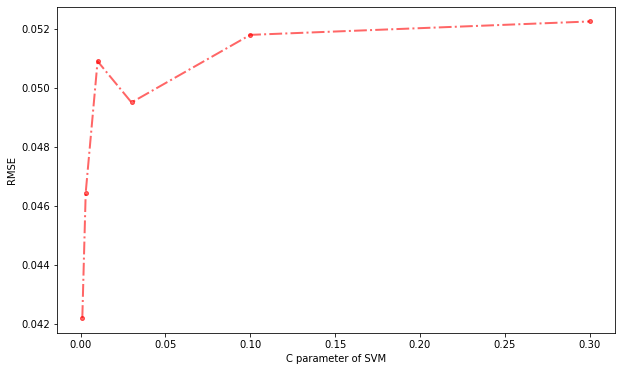

In [20]:
# Plot
plt.figure(figsize = (10, 6))
plt.plot(c_range, rms_mean, linestyle = '-.', linewidth = 2, color = 'r', alpha = 0.6, marker = 'o', markersize = 4)
plt.xlabel('C parameter of SVM')
plt.ylabel('RMSE')
plt.show

### Selection of activation function

In [13]:
kernels = ['linear', 'poly', 'rbf']
rms_mean = []

for kernel in kernels:
    svr = SVR(kernel=kernel, max_iter=1000000)
    rms = []
    
    svr.fit(X_train_split[technical_indicators], y_train_split['Close_after_1_day'])
    rms.append(score(horizons, y_valid_split, svr.predict(X_valid_split[technical_indicators])))
    svr.fit(X_train_split[fundamental_indicators], y_train_split['Close_after_1_day'])
    rms.append(score(horizons, y_valid_split, svr.predict(X_valid_split[fundamental_indicators])))
    svr.fit(X_train_split[combined_indicators], y_train_split['Close_after_1_day'])
    rms.append(score(horizons, y_valid_split, svr.predict(X_valid_split[combined_indicators])))
    
    print("c:"+str(kernel)+", mean:"+str(np.mean(rms)))
    
    rms_mean.append(np.mean(rms))

c:linear, mean:0.08407897717474859
c:poly, mean:0.05194176584740633
c:rbf, mean:0.08345102799010296


Text(0, 0.5, 'RMSE')

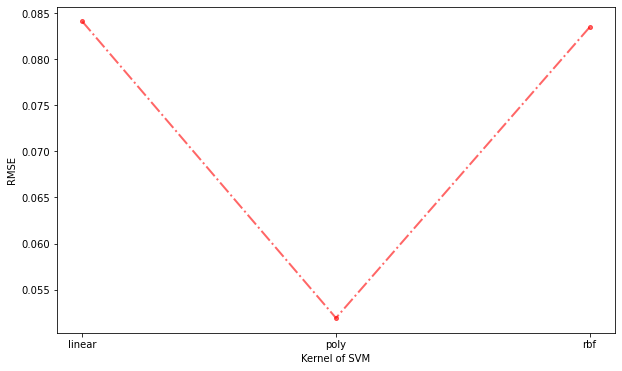

In [14]:
# Plot
plt.figure(figsize = (10, 6))
plt.plot(kernels, rms_mean, linestyle = '-.', linewidth = 2, color = 'r', alpha = 0.6, marker = 'o', markersize = 4)
plt.xlabel('Kernel of SVM')
plt.ylabel('RMSE')

### Selection of gamma parameters in rbf

In [24]:
gamma_range = [0.1, 0.3, 1, 3, 10]
rms_mean = []

for gamma in gamma_range:
    svr = SVR(C=0.001, kernel='poly', gamma=gamma, max_iter=1000000)
    rms = []
    
    svr.fit(X_train_split[technical_indicators], y_train_split['Close_after_1_day'])
    rms.append(score(horizons, y_valid_split, svr.predict(X_valid_split[technical_indicators])))
    svr.fit(X_train_split[fundamental_indicators], y_train_split['Close_after_1_day'])
    rms.append(score(horizons, y_valid_split, svr.predict(X_valid_split[fundamental_indicators])))
    svr.fit(X_train_split[combined_indicators], y_train_split['Close_after_1_day'])
    rms.append(score(horizons, y_valid_split, svr.predict(X_valid_split[combined_indicators])))
    
    print("gamma:"+str(gamma)+", mean:"+str(np.mean(rms)))
    
    rms_mean.append(np.mean(rms))

gamma:0.1, mean:0.12804611744725702
gamma:0.3, mean:0.09224666774124246
gamma:1, mean:0.040902024807128574
gamma:3, mean:0.052186937126124745
gamma:10, mean:0.052080238639424736


Text(0, 0.5, 'RMSE')

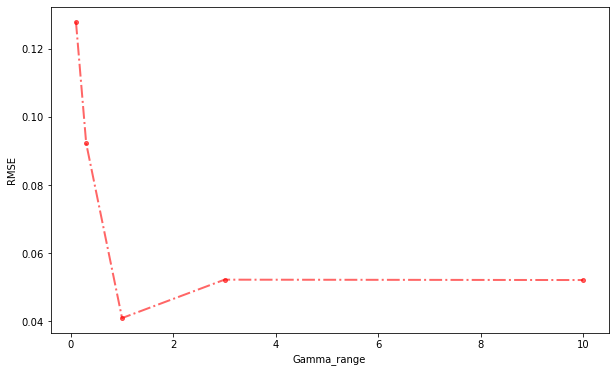

In [25]:
# Plot
plt.figure(figsize = (10, 6))
plt.plot(gamma_range, rms_mean, linestyle = '-.', linewidth = 2, color = 'r', alpha = 0.6, marker = 'o', markersize = 4)
plt.xlabel('Gamma_range')
plt.ylabel('RMSE')